In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

In [2]:
from latentrees import *

In [3]:
def param_freezer(func, *args, **kwargs):
    def wrapper(x):
        return func(x, *args, **kwargs)
    return wrapper

In [88]:
runtime = analyses()
params = [0.3,0.5,0.9,0.95,0.99,1,1.01,1.05,1.1,1.2,2,3]
for param in params:
    #runtime.append_model(L=50, distribution = param_freezer(lambda node, param: np.clip(rng.integres(node-param, node+param), -1e15, 1e15), param), name="{:.2f}".format(param))
    runtime.append_model(L=100, distribution = param_freezer(lambda node, param: np.clip(rng.normal(node, np.power(abs(node),param)), -1e15, 1e15), param), name="{:.2f}".format(param))
    #runtime.append_model(nl=param, L=50, name="negative_binom_{:d}".format(param))

#runtime.append_model(L=50, distribution = lambda node: np.clip(rng.normal(node, abs(node)), -1e15, 1e15), name="gaus_scaling")
print(runtime)
runtime.run()

analysis with 12 models: ['0.30 with 100 layers and 3 splits', '0.50 with 100 layers and 3 splits', '0.90 with 100 layers and 3 splits', '0.95 with 100 layers and 3 splits', '0.99 with 100 layers and 3 splits', '1.00 with 100 layers and 3 splits', '1.01 with 100 layers and 3 splits', '1.05 with 100 layers and 3 splits', '1.10 with 100 layers and 3 splits', '1.20 with 100 layers and 3 splits', '2.00 with 100 layers and 3 splits', '3.00 with 100 layers and 3 splits']
(analyses) - [INFO]: Running 0.30 with 100 layers and 3 splits
(models) - [INFO]: 0
(models) - [INFO]: 10
(models) - [INFO]: 20
(models) - [INFO]: 30
(models) - [INFO]: 40
(models) - [INFO]: 50
(models) - [INFO]: 60
(models) - [INFO]: 70
(models) - [INFO]: 80
(models) - [INFO]: 90
(analyses) - [INFO]: Running 0.50 with 100 layers and 3 splits
(models) - [INFO]: 0
(models) - [INFO]: 10
(models) - [INFO]: 20
(models) - [INFO]: 30
(models) - [INFO]: 40
(models) - [INFO]: 50
(models) - [INFO]: 60
(models) - [INFO]: 70
(models) -

In [68]:
moi_index = "3.00"
layers = runtime[moi_index].layers
L = runtime[moi_index].L
nl = runtime[moi_index].nl

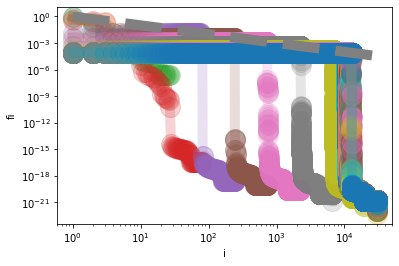

In [43]:
fig = plt.figure()

for l in range(L+1):
    freqs =np.abs(layers[l].sorted_nodes)
    x = np.linspace(1, len(freqs), len(freqs))
    plt.plot(x, np.sort(freqs)[::-1]/np.sum(freqs), marker="o", ms=20, lw=10, alpha=0.2)

plt.plot(x, 1/x, color="gray", lw=10, ls="--")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("i")
plt.ylabel("fi")
fig.show()

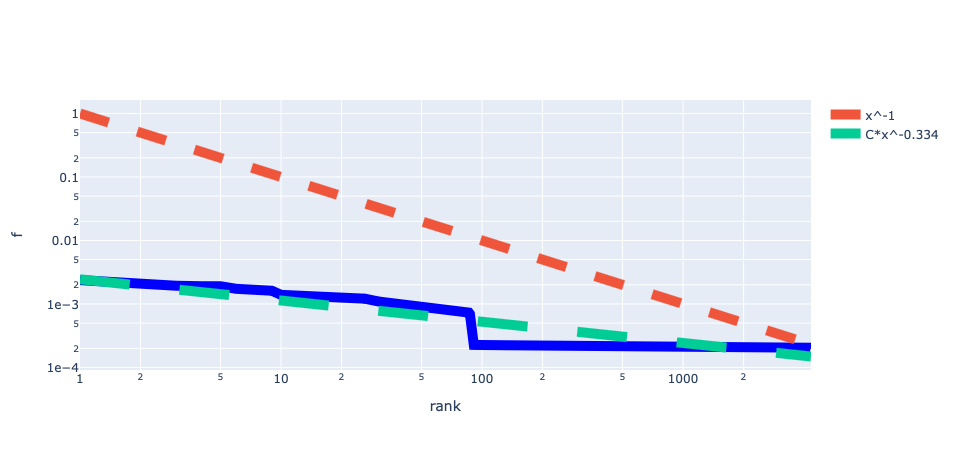

In [69]:
layer_of_interest = runtime[moi_index].layers[-1]
cnts = layer_of_interest.sorted_nodes
cnts = np.abs(cnts)
cnts = cnts[cnts<1e15]
cnts = cnts/cnts.sum()

x = np.linspace(1, len(cnts), len(cnts))

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=np.sort(cnts)[::-1], marker=dict(symbol="0", size=20, color="blue"), line_width=10, name="", showlegend=False))
fig.add_trace(go.Scatter(x=x, y=1/x, line_width=10, line_dash="dash",name="x^-1"))

fit_func = lambda x, C, gamma: C * np.power(x, - gamma)

popt, pcov = curve_fit(fit_func, x[:5000], cnts[:5000])
fig.add_trace(go.Scatter(x=x, y=fit_func(x, *popt), line_width=10, line_dash="longdash", name=f"C*x^-{round(popt[1],3)}"))

fig.update_xaxes(type="log", title="rank")
fig.update_yaxes(type="log", exponentformat="e", title="f")
#plt.ylim(1e-20,1)

In [ ]:
fig, axs = plt.subplots(1,5, figsize=(25,5))
for i,ax in enumerate(axs):
    loi = layers[i]
    leaves = loi.nodes[:1000]
    avg_leaves = loi.average
    sns.heatmap(list(map(lambda leaf_A: list(map(lambda leaf_B: np.abs(leaf_A[1]-leaf_B[1])/avg_leaves if leaf_A[0] < leaf_B[0] else 0,enumerate(leaves))),enumerate(leaves))), ax=ax)

# Last Layer

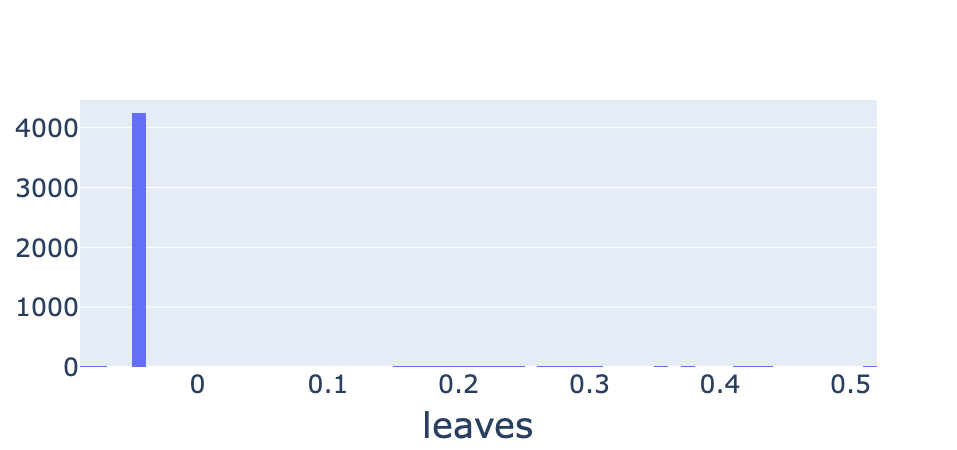

In [70]:
fig = go.Figure()
leaves = np.array(runtime[moi_index].layers[-1].nodes)
leaves = leaves[abs(leaves) < 1e15]
fig.add_trace(go.Histogram(x=leaves, nbinsx=100))

layout=dict(
xaxis=dict(title="leaves", title_font_size=35, tickfont_size=25),
yaxis=dict(tickfont_size=25)
)

fig.update_layout(layout)

## Histogram of distances

In [71]:
import multiprocessing as mp
import gc
def append_error(err):
    print(err)
        
def append_dist(d):
    global distances
    distances.append(d)
    
def measure_func(leaf_A):
    return list(map(lambda leaf_B: abs(leaf_A[1]-leaf_B[1]) if leaf_A[0] < leaf_B[0] else np.nan, enumerate(leaves)))

In [77]:
data = dict()
for model in runtime:
    loi = model.layers[-1]
    N = 500
    if len(loi)>N:
        leaves = np.random.choice(loi.nodes,size=N,replace=False)
    else:
        leaves = loi.nodes
    norm_leaves = max(loi.nodes)
    #print(norm_leaves)

    distances = []
    pool = mp.Pool(6) 
    res = pool.map_async(measure_func, enumerate(leaves), callback=append_dist, error_callback=append_error)
    pool.close()
    pool.join()
    distances = np.ravel(distances)
    #distances = np.ravel(list(map(lambda leaf: abs((leaf-avg_leaves)/norm_leave),enumerate(leaves))))
    #distances=distances/max([np.nanmax(distances),abs(np.nanmin(distances))])
    distances = distances[~np.isnan(distances)]
    #distances = distances[distances>=0]

    data[model.name]=distances
    loi = None
    gc.collect()

In [ ]:
#import pickle
#with open("data_distances.pkl","wb") as file:
#    pickle.dump(data, file)
#with open("data_distances.pkl","rb") as file:
#    data = pickle.load(file)

### distance vs param

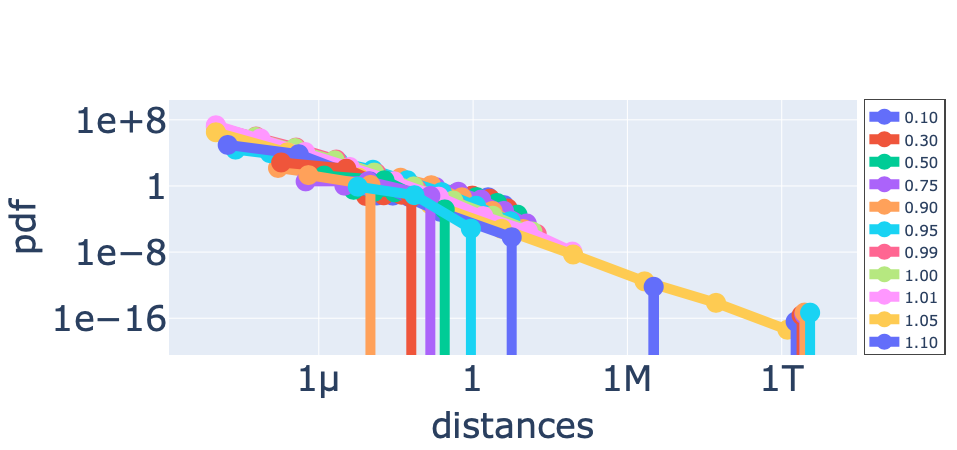

In [80]:
scale_distances = False

fig = go.Figure()

n_leaves = len(leaves)
for param,distances in data.items():
    try:
        if scale_distances:
            distances=distances/max([np.quantile(distances, 0.99),abs(np.nanmin(distances))])
            bins=np.linspace(0,np.quantile(distances, 0.99),15)
        else:
            bins=np.logspace(np.log10(distances[distances>1e-10].min()),np.log10(distances.max()), 10)
        bins, edges = np.histogram(distances, bins=bins, density=True)
        esges = (edges[1:]+edges[:1])/2
        fig.add_trace(go.Scatter(x=edges,y=bins,  marker=dict(size=20), line=dict(width=10), name=param))
    except:
        pass
    
fig.update_layout(xaxis=dict(title="distances", titlefont_size=35, tickfont_size=35, nticks= 5),
                 yaxis=dict(title="pdf", titlefont_size=35,tickfont_size=35, type="log", exponentformat="e", showexponent='all', nticks=4),
                 legend=dict(x=1.01,y=1,borderwidth=0.5,font_size=15,orientation="v"))

if not scale_distances:
    fig.update_xaxes(type="log")
fig.show()
#fig.write_image("images/pdf_distances.pdf")
#fig.write_html("images/pdf_distances.html")

### Distance vs layer

In [ ]:
fig = go.Figure()

for loi in runtime[-1].layers[::10]:
    N = 5000
    if len(loi)>N:
        leaves = np.random.choice(loi.nodes,size=N,replace=False)
    else:
        leaves = loi.nodes
    avg_leaves = loi.median
    
    distances = []
    pool = mp.Pool(6) 
    res = pool.map_async(measure_func, enumerate(leaves), callback=append_dist, error_callback=append_error)
    pool.close()
    pool.join()
    distances = np.ravel(distances)
    distances = distances[~np.isnan(distances)]
    
    n_leaves = len(leaves)

    bins=np.logspace(np.log10(1e-3),np.log10(distances.max()), 15)
    #bins=np.linspace(distances.min(),distances.max(),20)
    bins, edges = np.histogram(distances, bins=bins, density=True)
    esges = (edges[1:]+edges[:1])/2
    fig.add_trace(go.Scatter(x=edges,y=bins,  marker=dict(size=20), line=dict(width=10), name=loi.__repr__().split(",")[0]))

    gc.collect()
    
fig.update_layout(xaxis=dict(title="distances", titlefont_size=35, tickfont_size=35, exponentformat="e", type="log", nticks= 4),
                 yaxis=dict(title="pdf", titlefont_size=35,tickfont_size=35, type="log", exponentformat="e", showexponent='all', nticks=4),
                 legend=dict(x=1.01,y=1,borderwidth=0.5,font_size=15,orientation="v"))

fig.show()
#fig.write_image("images/distance_pdf_layers.pdf")
#fig.write_html("images/distance_pdf_layers.html")

# Hyperparameters

## gamma

In [81]:
def get_exp(layer)->float:
    try:
        layer_of_interest = layer
        cnts = layer_of_interest.sorted_nodes/np.sum(layer_of_interest.sorted_nodes)
        cnts = cnts[cnts<1e15]
        cnts = np.sort(np.abs(cnts))[::-1]
        x = np.linspace(1, len(cnts), len(cnts))

        popt, pcov = curve_fit(lambda x, C, gamma: C * np.power(x, - gamma), x[:10000], cnts[:10000])
        return popt[1]
    except:
        return np.nan

In [82]:
#exps = np.nanmean([list(map(get_exp, model.layers)) for model in runtime], axis=0)
#exps_errors = np.nanstd([list(map(get_exp, model.layers)) for model in runtime], axis=0)
exps = list(map(lambda m: get_exp(m.layers[-1]), runtime))
#exps = list(map(get_exp, runtime[moi_index].layers))

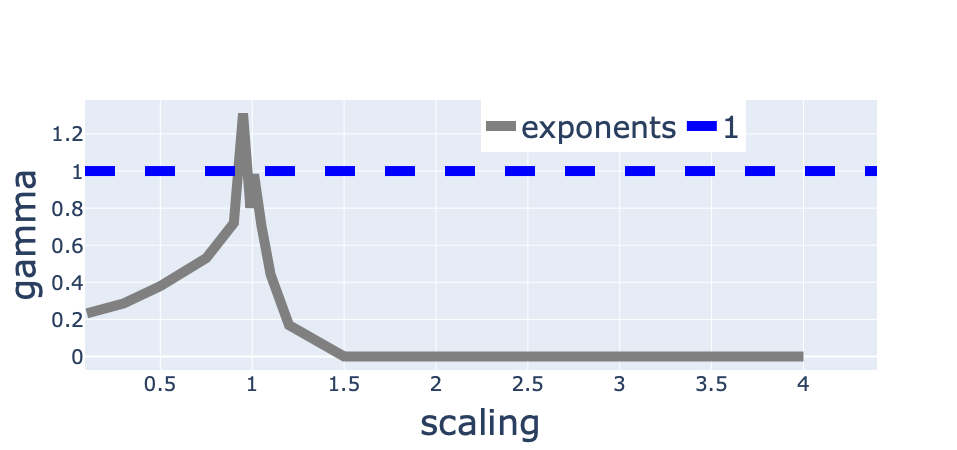

In [87]:
x, xlabel = params, "scaling"
#x, xlabel = np.linspace(1,len(exps),len(exps)), "Layer"

fig = go.Figure()

#fig.add_scatter(x = x, y=exps, error_y=dict(type="data", array=exps_errors, visible=True, width=8, thickness=3), name="exponents", mode="lines", marker=dict(size=10), line=dict(width=10, color="gray"))
fig.add_scatter(x = x, y=exps, name="exponents", mode="lines", marker=dict(size=10), line=dict(width=10, color="gray"))
fig.add_trace(go.Scatter(y=[1,1], x=[min(x)*0.9,max(x)*1.1], name="1", mode="lines", line=dict(width=10, color="blue", dash="dash")))


fig.update_traces(marker_size=20)
fig.update_layout(xaxis=dict(title=xlabel, exponentformat = 'e', tickfont=dict(size=20), title_font_size=35),
                  yaxis_title="gamma",
                  yaxis=dict(tickfont=dict(size=20), title_font=dict(size=35)),
                 legend=dict(font_size=30, orientation="h", x=0.5, y=1))
fig.show()

## nl

In [ ]:
exps = list(map(lambda m: get_exp(m.layers[-1]), runtime))

In [ ]:
fig = go.Figure()

fig.add_scatter(x = params, y=exps, name="exponents", mode="lines", marker=dict(size=10), line=dict(width=10, color="gray"))
fig.add_trace(go.Scatter(y=[1,1], x=[2,len(nls)+1], name="1", mode="lines", line=dict(width=10, color="blue", dash="dash")))


fig.update_traces(marker_size=20)
fig.update_layout(xaxis=dict(title="Number of <br> splits", exponentformat = 'e', tickfont=dict(size=20), title_font_size=35),
                  yaxis_title="gamma",
                  yaxis=dict(range=(0,4.5),tickfont=dict(size=20), title_font=dict(size=35)),
                 legend=dict(font_size=30, orientation="h", x=0.5, y=1))
fig.show()

## Heaps

In [ ]:
h = [len(np.unique(m.layers[-1].nodes)) for m in runtime]
M = np.array([np.sum(m.layers[-1].nodes) for m in runtime])

In [ ]:
x = np.linspace(min(M), max(M), 10)

fig = make_subplots(cols=2, rows=1)

popt,pcov = curve_fit(lambda x, C, gamma: C*np.power(x,gamma), M, h)

fig.add_scatter(x=M,y=h, mode="markers", marker=dict(size=20, color="gray"), showlegend=False, row=1, col=1)

popt, pcov = curve_fit(lambda x, C, exp: C*np.power(x,exp), M, h)
fig.add_scatter(x=M,y=popt[0]*np.power(M,popt[1]), mode="lines", line=dict(width=10, color="red", dash="dot"), name="teo exp={:.2f}".format(popt[1]), row=1, col=1)


bins = np.logspace(np.log10(M.min()),np.log10(M.max()),15)
means, edges, _ = binned_statistic(M,h, statistic="mean", bins=bins)
var, edges, _ = binned_statistic(M,h, statistic="std", bins=bins)
var = var*var
cnt, edges, _ = binned_statistic(M,h, statistic="count", bins=bins)

mask = cnt > 10

fig.add_scatter(x=(edges[1:]+edges[:-1])[mask]/2, y=means[mask], mode="markers+lines", line=dict(width=10, color="blue", dash="dot"), marker=dict(size=15), name="binned avg", row=1, col=1)


fig.update_xaxes(type="log", 
                 title="M",
                 title_font_size=30, 
                 tickfont_size=25, 
                 exponentformat="e", 
                 showexponent="all", 
                 tickangle=300,
                 row=1, col=1)
                 
fig.update_yaxes(type="log",
                 title="h",
                 title_font_size=30, 
                 tickfont_size=25, 
                 nticks=5,
                 row=1, col=1)

x = np.linspace(min(means), max(means), 10)
fig.add_trace(go.Scatter(x=means[mask],y=var[mask], mode="markers", marker = dict(size=20),showlegend=False), row=1, col=2)
fig.add_traces([
    go.Scatter(x=x, y=x, name="Poisson", mode="lines", line=dict(width=10, dash="dashdot")),
    go.Scatter(x=x, y=x**2, name="Taylor", mode="lines", line=dict(width=10, dash="longdashdot"))
],rows=1, cols=2)

fig.update_xaxes(type="log", 
                 title="<h>",
                 title_font_size=30, 
                 tickfont_size=25, 
                 exponentformat="e", 
                 showexponent="all", 
                 tickangle=300,
                 row=1, col=2)
                 
fig.update_yaxes(type="log",
                 title="var<h>",
                 title_font_size=30, 
                 tickfont_size=25, 
                 nticks=2,
                 row=1, col=2)

fig.update_layout(legend=dict(font_size=20, orientation="h", x=0.1,y=1.2),width=1500, height=800)
fig.show()
fig.write_image("images/heaps.pdf")
fig.write_html("images/heaps.html")

In [ ]:
import gc
gc.collect()